In [4]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Net") \
    .getOrCreate()

In [5]:
import pandas as pd

In [33]:
import pyspark.sql.functions as F
from pyspark.sql.functions import round
from pyspark.sql.functions import count
from pyspark.sql.functions import array, col, explode, struct, lit

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

import itertools
from math import sqrt
from operator import add
import sys
from pyspark.ml.recommendation import ALS

from pyspark.ml.evaluation import RegressionEvaluator

[375.0, 300.0, 75.0, 50.0, 55.0, 95.0, 250.0]
['U.S. Large Cap Blend', 'U.S. Large Cap Value', 'U.S. Short-Term Bonds', 'U.S. Small Cap Blend', 'U.S. Small Cap Value', 'U.S. Real Estate', 'Intermediate-Term Bonds']


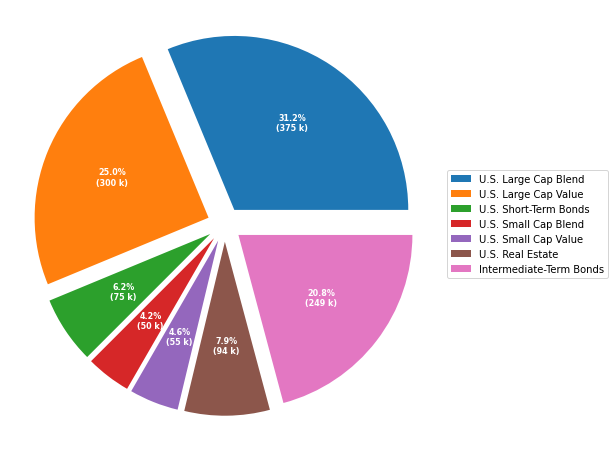

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

recipe = ["375 k U.S. Large Cap Blend",
          "300 k U.S. Large Cap Value",
          "75 k U.S. Short-Term Bonds",
          "50 k U.S. Small Cap Blend",
          "55 k U.S. Small Cap Value",
          "95 k U.S. Real Estate",
          "250 k Intermediate-Term Bonds"]

data = [float(x.split()[0]) for x in recipe]
ingredients = [' '.join(x.split()[2:]) for x in recipe]

print(data)
print(ingredients)
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} k)".format(pct, absolute)

explode = np.empty(len(data))#(0.1, 0.1, 0.1,  0.1, 0.1, 0.1)  # explode 1st slice
explode.fill(0.1)

wedges, texts, autotexts = ax.pie(data, explode=explode, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          #title="Stock portfolio",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

plt.show()

In [8]:
df_raw = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load("data/Online Retail.csv",header=True)

df_raw.show(5)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
only showing top 5 rows



In [9]:
def my_count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()

In [10]:
df_raw = df_raw.withColumn('Asset',round( F.col('Quantity') * F.col('UnitPrice'), 2 ))
df = df_raw.withColumnRenamed('StockCode', 'Cusip')\
           .select('CustomerID','Cusip','Quantity','UnitPrice','Asset')

my_count(df)

+----------+-----+--------+---------+-----+
|CustomerID|Cusip|Quantity|UnitPrice|Asset|
+----------+-----+--------+---------+-----+
|     58567|90995|   90995|    90994|90994|
+----------+-----+--------+---------+-----+



In [11]:
df =  df.filter(F.col('Asset')>=0)
df = df.dropna(how='any')
my_count(df)

+----------+-----+--------+---------+-----+
|CustomerID|Cusip|Quantity|UnitPrice|Asset|
+----------+-----+--------+---------+-----+
|     56883|56883|   56883|    56883|56883|
+----------+-----+--------+---------+-----+



In [12]:
# функция для форматирования Cusip
def toUpper(s):
    return s.upper()

upper_udf = udf(lambda x: toUpper(x), StringType())

In [13]:
pop = df.groupBy('Cusip')\
          .agg(F.count('CustomerID').alias('Customers'),F.round(F.sum('Asset'),2).alias('TotalAsset'))\
          .sort([F.col('Customers'),F.col('TotalAsset')],ascending=[0,0])

pop.show(5)

+------+---------+----------+
| Cusip|Customers|TotalAsset|
+------+---------+----------+
|85123A|      434|   27607.0|
| 22423|      304|   33739.2|
| 22469|      273|   8379.84|
| 22720|      244|    7617.9|
| 22470|      229|   9534.02|
+------+---------+----------+
only showing top 5 rows



### Делаем матрицу фичей

In [14]:
# отбор топ 10 акций 
top = 10
cusip_lst = pd.DataFrame(pop.select('Cusip').head(top)).astype('str').iloc[:, 0].tolist()
cusip_lst.insert(0,'CustomerID')

In [15]:
# создаем портфолию для каждоо пользователя
pivot_tab = df.groupBy('CustomerID').pivot('Cusip').sum('Asset')
pivot_tab = pivot_tab.fillna(0)

In [16]:
# cross-tab по топовым акциям
selected_tab  = pivot_tab.select(cusip_lst)
selected_tab.show(4)

+----------+------+-----+-----+-----+-----+-----+------+-----+-----+-----+
|CustomerID|85123A|22423|22469|22720|22470|22961|85099B|84879|21733|22960|
+----------+------+-----+-----+-----+-----+-----+------+-----+-----+-----+
|     16503|   0.0|  0.0|  0.0|  0.0|  0.0|  0.0|   0.0|  0.0|  0.0|  0.0|
|     15727|  23.6|  0.0| 36.3| 69.3| 64.9| 34.8|   0.0|  0.0|  0.0|  0.0|
|     17389|   0.0|  0.0|  0.0|  0.0|  0.0|  0.0|   0.0|  0.0|  0.0|  0.0|
|     13623|   0.0|  0.0|  0.0|  0.0|  0.0|  0.0|   0.0|  0.0|  0.0|  0.0|
+----------+------+-----+-----+-----+-----+-----+------+-----+-----+-----+
only showing top 4 rows



### делаем матрицу рейтингов

In [17]:
selected_tab.columns

['CustomerID',
 '85123A',
 '22423',
 '22469',
 '22720',
 '22470',
 '22961',
 '85099B',
 '84879',
 '21733',
 '22960']

In [18]:
def elemwiseDiv(df_in):
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    
    num = len(df_in.columns)
    temp = df_in.rdd.map(lambda x: flatten(list([[x[0]],[x[i]/float(sum(x[1:])) if sum(x[1:])>0 else x[i] for i in range(1,num)]])))
    
    # показать, что выводит без flatten
    # return temp
    return spark.createDataFrame(temp, df_in.columns)

ratings = elemwiseDiv(selected_tab)
ratings.show(5)

+----------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------+------------------+-----+-----+
|CustomerID|             85123A|             22423|              22469|              22720|              22470|              22961|85099B|             84879|21733|22960|
+----------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------+------------------+-----+-----+
|     16503|                0.0|               0.0|                0.0|                0.0|                0.0|                0.0|   0.0|               0.0|  0.0|  0.0|
|     15727|0.10310179117518568|               0.0|0.15858453473132372|0.30275229357798167|0.28352992573176067|0.15203145478374835|   0.0|               0.0|  0.0|  0.0|
|     17389|                0.0|               0.0|                0.0|                0.0|                0.0|                0.0|   0.0|            

### матрицу в таблицу

- CustomerId
- Cusip
- rating

In [45]:
def to_long(df, by):
    """
    reference: https://stackoverflow.com/questions/37864222/transpose-column-to-row-with-spark
    """
    
    
    # делаем разбивку на колонки и типы, получаем список
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    
    # Spark SQL проверка на типы (все транспонируемые колонки должны быть одного типа)
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # созаем структуру из (column_name, column_value) structs
    kvs = explode(array([struct(lit(c).alias("Cusip"), col(c).alias("rating")) for c in cols])).alias("kvs")
    
    # возвращаем новый DF
    return df.select(by + [kvs]).select(by + ["kvs.Cusip", "kvs.rating"])

In [46]:
df_all = to_long(ratings,['CustomerID'])
df_all.show(5)

+----------+------+------+
|CustomerID| Cusip|rating|
+----------+------+------+
|     16503|85123A|   0.0|
|     16503| 22423|   0.0|
|     16503| 22469|   0.0|
|     16503| 22720|   0.0|
|     16503| 22470|   0.0|
+----------+------+------+
only showing top 5 rows



In [47]:
# Cusip в индекс
from pyspark.ml.feature import StringIndexer
# Cusip проиндексируем
labelIndexer = StringIndexer(inputCol='Cusip',
                             outputCol='indexedCusip').fit(df_all)
df_all = labelIndexer.transform(df_all)

df_all.show(5, True)
df_all.printSchema()

+----------+------+------+------------+
|CustomerID| Cusip|rating|indexedCusip|
+----------+------+------+------------+
|     16503|85123A|   0.0|         9.0|
|     16503| 22423|   0.0|         1.0|
|     16503| 22469|   0.0|         2.0|
|     16503| 22720|   0.0|         4.0|
|     16503| 22470|   0.0|         3.0|
+----------+------+------+------------+
only showing top 5 rows

root
 |-- CustomerID: long (nullable = true)
 |-- Cusip: string (nullable = false)
 |-- rating: double (nullable = true)
 |-- indexedCusip: double (nullable = false)



### Train model

In [48]:
train, test = df_all.randomSplit([0.8,0.2])

train.show(5)
test.show(5)

+----------+-----+------+------------+
|CustomerID|Cusip|rating|indexedCusip|
+----------+-----+------+------------+
|     13623|21733|   0.0|         0.0|
|     13623|22469|   0.0|         2.0|
|     13623|22470|   0.0|         3.0|
|     13623|22720|   0.0|         4.0|
|     13623|22960|   0.0|         5.0|
+----------+-----+------+------------+
only showing top 5 rows

+----------+------+------+------------+
|CustomerID| Cusip|rating|indexedCusip|
+----------+------+------+------------+
|     13623| 22423|   0.0|         1.0|
|     14450| 21733|   0.0|         0.0|
|     14450| 22961|   0.0|         6.0|
|     14450|85123A|   0.0|         9.0|
|     15447| 22469|   0.0|         2.0|
+----------+------+------+------------+
only showing top 5 rows



In [49]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
def computeRmse(model, data):
    """
    Compute RMSE (Root mean Squared Error).
    """
    predictions = model.transform(data)
    rmse = evaluator.evaluate(predictions)
    print("Root-mean-square error = " + str(rmse))
    return rmse

#train и оценка качества
ranks = [4,5]
lambdas = [0.01]
numIters = [5]
bestModel = None
bestValidationRmse = float("inf")
bestRank = 0
bestLambda = -1.0
bestNumIter = -1

val = test.na.drop()
for rank, lmbda, numIter in itertools.product(ranks, lambdas, numIters):
    als = ALS(rank=rank, maxIter=numIter, regParam=lmbda, numUserBlocks=10, numItemBlocks=10, implicitPrefs=False,
              alpha=1.0,
              userCol="CustomerID", itemCol="indexedCusip", seed=1, ratingCol="rating", nonnegative=True)
    model=als.fit(train)

    validationRmse = computeRmse(model, val)
    print("RMSE (validation) = %f for the model trained with " % validationRmse + \
            "rank = %d, lambda = %.1f, and numIter = %d." % (rank, lmbda, numIter))
    if (validationRmse, bestValidationRmse):
        bestModel = model
        bestValidationRmse = validationRmse
        bestRank = rank
        bestLambda = lmbda
        bestNumIter = numIter

model = bestModel

Root-mean-square error = 0.24187789130363269
RMSE (validation) = 0.241878 for the model trained with rank = 4, lambda = 0.0, and numIter = 5.
Root-mean-square error = 0.24474557391042706
RMSE (validation) = 0.244746 for the model trained with rank = 5, lambda = 0.0, and numIter = 5.


In [50]:
topredict=test[test['rating']==0]

predictions=model.transform(topredict)
predictions.filter(predictions.prediction>0)\
           .sort([F.col('CustomerID'),F.col('Cusip')],ascending=[0,0]).show(5)

+----------+------+------+------------+------------+
|CustomerID| Cusip|rating|indexedCusip|  prediction|
+----------+------+------+------------+------------+
|     18283|85123A|   0.0|         9.0|  0.33576784|
|     18283| 84879|   0.0|         7.0|  0.12090129|
|     18283| 22961|   0.0|         6.0|  0.29869595|
|     18260| 22960|   0.0|         5.0| 0.005875939|
|     18260| 22720|   0.0|         4.0|0.0114774965|
+----------+------+------+------------+------------+
only showing top 5 rows

